<a href="https://colab.research.google.com/github/mohitx84/Age-Gender-And-Race-Prediction/blob/main/Age_Gender_and_Race_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Dataset

In [1]:
import kagglehub
jangedoo_utkface_new_path = kagglehub.dataset_download('jangedoo/utkface-new')

print('Data Set Imported Sucessfully.')

Data Set Imported Sucessfully.


In [2]:
pip install tensorflow


Importing Required Libraries

In [3]:
#Import necessary Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications, losses, optimizers, metrics
from sklearn.model_selection import train_test_split

Dataset Directory

In [4]:
#dataset directory
DATASET_DIR = '/kaggle/input/utkface-new/UTKFace'
os.listdir(DATASET_DIR)[0:3]

['26_0_2_20170104023102422.jpg.chip.jpg',
 '22_1_1_20170112233644761.jpg.chip.jpg',
 '21_1_3_20170105003215901.jpg.chip.jpg']

From above we find that there is age_gender_race_img_name so, we need to divide them


# **Creating the dataset**

In [5]:
import os
from PIL import Image

images = []
ages = []
genders = []
races = []

folder = '/kaggle/input/utkface-new/UTKFace'

#converting the name into a datasetlike age_gender_race_image into 4 columns
for filename in os.listdir(folder)[:8000]:
    split = filename.split('_')
    #some images didn't have the race value
    if len(split) >= 4:
        try:
            age = int(split[0])
            gender = int(split[1])
            race = int(split[2])
            img_path = os.path.join(folder, filename)
            image = Image.open(img_path)

            ages.append(age)
            genders.append(gender)
            races.append(race)
            images.append(image)
        except Exception as e:
            print(f"Skipping file {filename}: {e}")
    else:
        print(f"Skipping malformed filename: {filename}")

Skipping malformed filename: 61_1_20170109142408075.jpg.chip.jpg


Differentiating images into the images, ages, genders and races and change them to the dataframe to make a dataset and for making it easy for you

In [6]:
#Change the above series into the dataframe
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
races = pd.Series(list(races), name = 'Races')

#Convert them to the dataset
df = pd.concat([images, ages, genders, races], axis=1)
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0,2
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1,3
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1,4


Map the Gender and Races for easily analysing Dataset


In [7]:
# Map gender and race BEFORE putting into the DataFrame
gender_map = {0: 'm', 1: 'f'}
race_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Convert genders and races using mapping
genders_mapped = [gender_map[o] for o in genders]
races_mapped = [race_map[o] for o in races]

# Convert to pandas Series
images_series = pd.Series(images, name='img_name')
ages_series = pd.Series(ages, name='age')
genders_series = pd.Series(genders_mapped, name='gender')
races_series = pd.Series(races_mapped, name='race')

# Combine into a DataFrame
df = pd.concat([images_series, ages_series, genders_series, races_series], axis=1)

# Show the DataFrame
df.head()

,img_name,age,gender,race
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,m,Asian
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,f,Black
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,f,Indian
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,m,White
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,f,Others


 Dividing in Train and Test

In [8]:
#divinding into the train and test sets
df['is_train'] = np.random.choice(2, size=len(df), p=[0.2, 0.8])
df.head()

,img_name,age,gender,race,is_train
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,m,Asian,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,f,Black,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,f,Indian,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,m,White,1
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,f,Others,1


# **Visualising Dataset**

<Axes: >

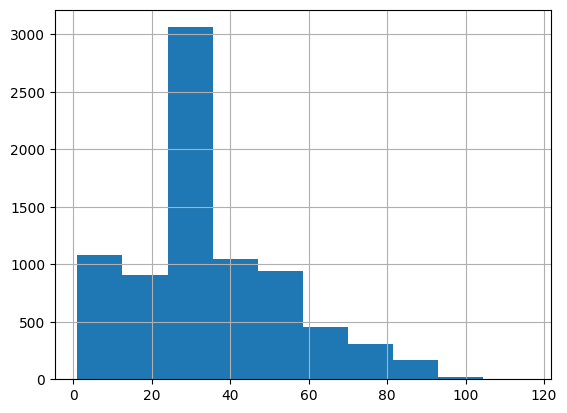

In [9]:
df.age.hist()

<Axes: >

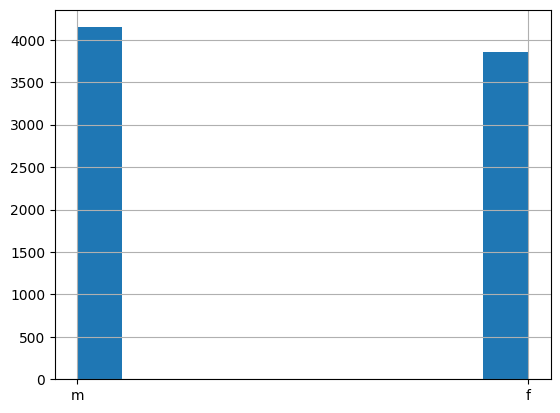

In [10]:
df.gender.hist()

<Axes: >

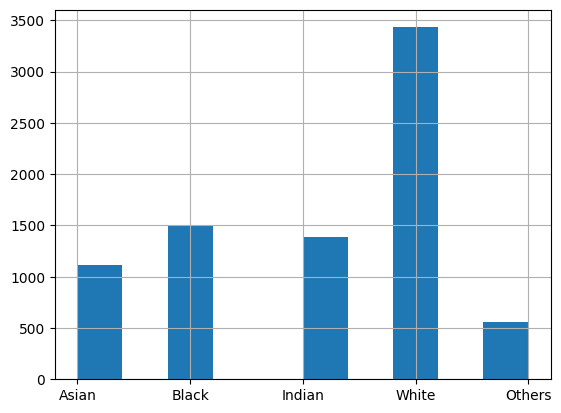

In [11]:
df.race.hist()

Checking Random Samples of dataset


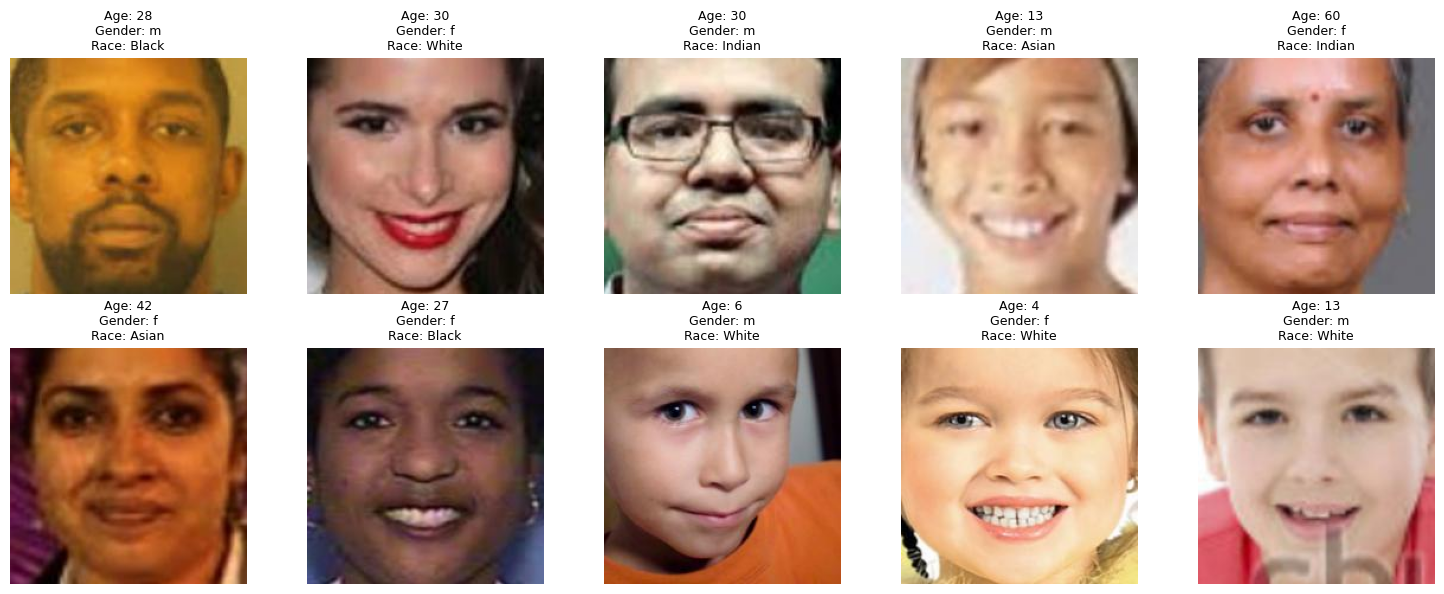

In [12]:
import matplotlib.pyplot as plt

def show_random_samples(df, n=10):
    # Get random samples
    samples = df.sample(n=n, random_state=10)

    # Create subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(samples.iterrows()):
        # Convert PIL image to array and display
        img_array = np.array(row['img_name'])
        axes[i].imshow(img_array)

        # Add title with demographic info
        title = f"Age: {row['age']}\nGender: {row['gender']}\nRace: {row['race']}"
        axes[i].set_title(title, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Run it
show_random_samples(df)

Converting This to Numerical So that can be used for Model Training

In [13]:
# Convert categorical labels to numerical for model training
df['gender'] = df['gender'].map({'m': 0, 'f': 1})
df['race'] = df['race'].map({'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4})

# Split data into train and test using the 'is_train' column
train_df = df[df['is_train'] == 1]
test_df = df[df['is_train'] == 0]

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Train samples: 6394, Test samples: 1605


Creating Dataset

In [14]:
class PILDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, target_size=(200, 200)):
        self.df = df
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data at the end of each epoch
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        images = []
        ages = []
        genders = []
        races = []

        for _, row in batch_df.iterrows():
            # Directly use the PIL image from DataFrame
            img = row['img_name']

            # Ensure image is RGB (some might be grayscale)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Convert to array and resize if needed
            if img.size != self.target_size:
                img = img.resize(self.target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0,1]

            images.append(img_array)
            ages.append(row['age'])
            genders.append(row['gender'])
            races.append(row['race'])

        # One-hot encode race for classification
        races_onehot = tf.keras.utils.to_categorical(races, num_classes=5)

        return np.array(images), {
            'age_output': np.array(ages),
            'gender_output': np.array(genders),
            'race_output': races_onehot
        }

In [15]:
# Create data generators
train_gen = PILDataGenerator(train_df, batch_size=32)
test_gen = PILDataGenerator(test_df, batch_size=32)

Bulding Multitask Model

In [16]:
def build_multi_task_model(input_shape=(200, 200, 3)):
    # Use MobileNetV2 as base for transfer learning
    base_model = applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = True  # Fine-tune the base model

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)

    # Shared Feature Extraction Layers
    shared = layers.Dense(512, activation='relu')(x)
    shared = layers.Dropout(0.5)(shared)

    # Task-Specific Heads
    # Age prediction (regression)
    age_head = layers.Dense(256, activation='relu')(shared)
    age_head = layers.Dropout(0.3)(age_head)
    age_head = layers.Dense(128, activation='relu')(age_head)
    age_output = layers.Dense(1, name='age_output')(age_head)

    # Gender prediction (binary classification)
    gender_head = layers.Dense(128, activation='relu')(shared)
    gender_head = layers.Dropout(0.2)(gender_head)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_head)

    # Race prediction (multi-class classification)
    race_head = layers.Dense(256, activation='relu')(shared)
    race_head = layers.Dropout(0.3)(race_head)
    race_head = layers.Dense(128, activation='relu')(race_head)
    race_output = layers.Dense(5, activation='softmax', name='race_output')(race_head)

    return models.Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

In [17]:
# Build and compile model
model = build_multi_task_model()
model.summary()

/tmp/ipython-input-16-762489061.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,308,871 (12.62 MB)

 Trainable params: 3,274,759 (12.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Defining Loss Function

In [18]:
# Custom loss weights to balance tasks
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss={
        'age_output': losses.MeanAbsoluteError(),
        'gender_output': losses.BinaryCrossentropy(),
        'race_output': losses.CategoricalCrossentropy()
    },
    loss_weights={
        'age_output': 0.5,  # Less weight for age (regression is harder)
        'gender_output': 1.0,
        'race_output': 1.0
    },
    metrics={
        'age_output': ['mae'],
        'gender_output': ['accuracy'],
        'race_output': ['accuracy']
    }
)

In [19]:
# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

Training The Model

In [20]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 257ms/step - age_output_loss: 19.8205 - age_output_mae: 19.8233 - gender_output_accuracy: 0.6237 - gender_output_loss: 0.6837 - loss: 12.1413 - race_output_accuracy: 0.3781 - race_output_loss: 1.5460 - val_age_output_loss: 9.7010 - val_age_output_mae: 9.6800 - val_gender_output_accuracy: 0.7583 - val_gender_output_loss: 0.4879 - val_loss: 6.6534 - val_race_output_accuracy: 0.5202 - val_race_output_loss: 1.3192 - learning_rate: 1.0000e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - age_output_loss: 7.6801 - age_output_mae: 7.6811 - gender_output_accuracy: 0.7759 - gender_output_loss: 0.4747 - loss: 5.5296 - race_output_accuracy: 0.5383 - race_output_loss: 1.2149 - val_age_output_loss: 13.0454 - val_age_output_mae: 13.1266 - val_gender_output_accuracy: 0.7994 - val_gender_output_loss: 0.4328 - val_loss: 8.1071 - val_race_output_accuracy: 0.5913 - val_race_output_loss: 1.1125 - learning_rate: 1.0000e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━

In [21]:
#save the model
model.save('/kaggle/working/multi_task_model.h5')

In [22]:
results = model.evaluate(test_gen)
print("\nEvaluation Results:")
print(f"Age MAE: {results[4]:.2f} years")
print(f"Gender Accuracy: {results[5]*100:.2f}%")
print(f"Race Accuracy: {results[6]*100:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - age_output_loss: 6.0885 - age_output_mae: 6.0868 - gender_output_accuracy: 0.8791 - gender_output_loss: 0.3280 - loss: 4.2507 - race_output_accuracy: 0.7367 - race_output_loss: 0.8789

Evaluation Results:
Age MAE: 6.09 years
Gender Accuracy: 87.66%
Race Accuracy: 75.45%


# **Predict Using Model**

In [23]:
def predict_demographics(model, pil_image, target_size=(200, 200)):
    """Predict age, gender and race from PIL image"""
    # Preprocess image
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    if pil_image.size != target_size:
        pil_image = pil_image.resize(target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(pil_image)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    age_pred, gender_pred, race_pred = model.predict(img_array)

    # Convert to human-readable format
    gender_map = {0: 'Male', 1: 'Female'}
    race_map = {
        0: 'White',
        1: 'Black',
        2: 'Asian',
        3: 'Indian',
        4: 'Others'
    }

    return {
        'age': age_pred[0][0],
        'gender': gender_map[1 if gender_pred[0][0] > 0.5 else 0],
        'race': race_map[np.argmax(race_pred[0])]
    }

In [24]:
# Test the prediction on a sample from test set
sample = test_df.iloc[0]
result = predict_demographics(model, sample['img_name'])

print("\nSample Prediction:")
print(f"  Image index: {sample.name}")
print(f"  Predicted: Age={result['age']:.1f}, Gender={result['gender']}, Race={result['race']}")
print(f"  Actual:    Age={sample['age']}, Gender={gender_map[sample['gender']]}, Race={race_map[sample['race']]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Sample Prediction:
  Image index: 0
  Predicted: Age=25.6, Gender=Female, Race=Asian
  Actual:    Age=26, Gender=m, Race=Asian


# **Visualising Training Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


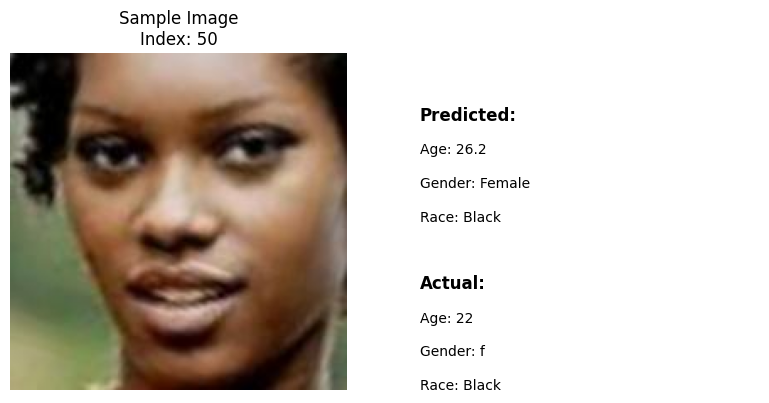

In [25]:
# Enhanced prediction display with image visualization
sample = test_df.iloc[10]
result = predict_demographics(model, sample['img_name'])

# Create figure
plt.figure(figsize=(8, 4))

# Show image
plt.subplot(1, 2, 1)
plt.imshow(np.array(sample['img_name']))
plt.title(f"Sample Image\nIndex: {sample.name}")
plt.axis('off')

# Show prediction vs actual
plt.subplot(1, 2, 2)
plt.text(0.1, 0.8, "Predicted:", fontsize=12, weight='bold')
plt.text(0.1, 0.7, f"Age: {result['age']:.1f}", fontsize=10)
plt.text(0.1, 0.6, f"Gender: {result['gender']}", fontsize=10)
plt.text(0.1, 0.5, f"Race: {result['race']}", fontsize=10)

plt.text(0.1, 0.3, "Actual:", fontsize=12, weight='bold')
plt.text(0.1, 0.2, f"Age: {sample['age']}", fontsize=10)
plt.text(0.1, 0.1, f"Gender: {gender_map[sample['gender']]}", fontsize=10)
plt.text(0.1, 0.0, f"Race: {race_map[sample['race']]}", fontsize=10)

plt.axis('off')
plt.tight_layout()
plt.show()

# **Visualising Training History**

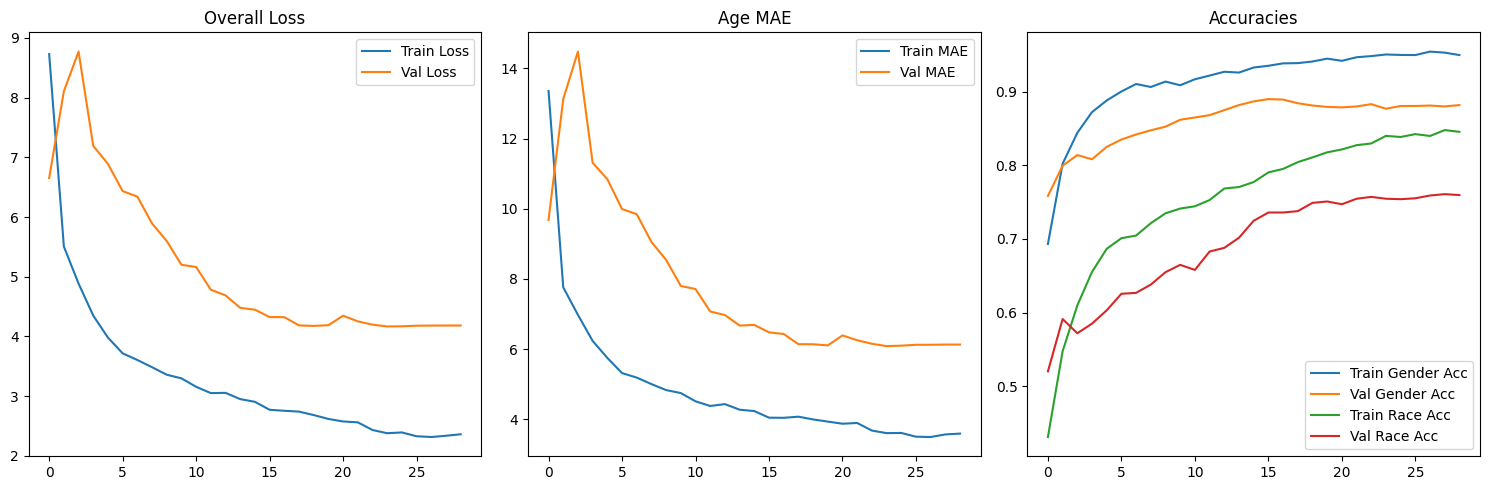

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Overall Loss')
plt.legend()

# Plot age MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Val MAE')
plt.title('Age MAE')
plt.legend()

# Plot accuracies
plt.subplot(1, 3, 3)
plt.plot(history.history['gender_output_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Acc')
plt.plot(history.history['race_output_accuracy'], label='Train Race Acc')
plt.plot(history.history['val_race_output_accuracy'], label='Val Race Acc')
plt.title('Accuracies')
plt.legend()

plt.tight_layout()
plt.show()